# Семинар 12. Self-supervised обучение

## Содержание семинара
На этом семинаре мы
1. Вспомним постановку задачи self-supervised обучения для изображений
2. Детально разберём архитектуру модели для контрастного обучения типа [SimCLR](https://arxiv.org/abs/2002.05709)
3. Предобучим с помощью контрастной функции потерь модель на наборе данных [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)
4. Оценим пользу такого предобучения для задачи semi-supervised классификации, в которой мы знаем истинные классы только для части выборки
5. Выясним, на примере набора данных [Caltech 101](https://data.caltech.edu/records/mzrjq-6wc02), как можно использовать предобученные на больших наборах данных модели для эффективного решения задачи классификации на наших данных

## 1. Self-supervised методы обучения
Self-supervied обучение модели это способ извлечения осмысленной информации из большого набора неразмеченных данных  

Мы хотим обучить модель, которая, будет по изображению вычислять вектор представления,  
хорошо описывающий объекты, находящиеся на изображении  

Затем эту модель можно использовать, например, для классификации изображений из нового набора данных

## 2. Контрастное обучение с SimCLR
[SimCLR](https://arxiv.org/abs/2002.05709) (Simple Contrastive Learning Representation): self-supervised модель, которая используется для получения осмысленных представлений изображений

<img src="../images/simclr_im1.png" alt="drawing" width="600"/>

<center><img src="../images/simclr_im4.png" alt="drawing" width="800"/><center/>

<center><img src="../images/simclr_im2.png" alt="drawing" width="900"/><center/>

Из набора данных выбираем $N$ изображений и для каждого из них получаем 2 изображения, используя 2 случаных преобразования (кроп, изменение цвета) исходного изображения. 

Пару изображений, полученных от одного изображения будем называть положительной парой, иначе отрицательной.  
Теперь мы имеем $2N$ изображений

<center><img src="../images/simclr_im3.png" alt="drawing" width="800"/><center/>

Для каждой пары положительной пары $(i,j)$ определим функцию потерь, которая вынуждает модель  
выдавать близкие по метрике эмбеддинги для положительных пар, и далёкие для отрицательных:


$$
l_{i,j} = -\log\frac{\exp(\text{sim}(\textbf{z}_i, \textbf{z}_j)/\tau)}{\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(\textbf{z}_i,\textbf{z}_k)/\tau)}
$$

$$
\text{sim}(\textbf{u}, \textbf{v}) = \textbf{u}^T\textbf{v}/\left\lVert\textbf{u}\right\rVert \left\lVert\textbf{v}\right\rVert
$$

Итоговая функция потерь:

$$
\mathcal{L} = \frac{1}{2N}\sum_{k=1}^N[l(2k-1,2k) + l(2k, 2k - 1)]
$$


## 3. Предобучение на CIFAR-10
Обучим модель извлечения признаков изображений на наборе данных [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html). Для обучения эмбеддингов будем использовать контрастную функцию потерь.

In [1]:
import torchvision
import torch
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch.nn.functional as F
from torch import nn
import shutil

from utils import AverageMeter, ProgressMeter, accuracy, evaluate_classifier
import time
from torchvision import transforms

%load_ext autoreload
%autoreload 2

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

/home/devel/miniconda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Задание энкодера

В качестве энкодера будем использовать модификацию [ResNet-50](https://arxiv.org/abs/1512.03385)

Так как разрешение изображений в наборе данных [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html), меньше чем в на наборе данных [ImageNet](https://www.image-net.org/) (целевой набор данных для разработчиков ResNet-50), мы заменим первый свёрточный слой с ядром $(7\times 7)$ и страйдом $2$, на свёрточный слой с ядром размера $(3\times3)$ и страйдом $1$  
Также мы удалим первый maxpolling слой

In [2]:
resnet50 = torchvision.models.resnet50(pretrained=False).to(device)

new_modules = [
    nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
] + list(resnet50.children())[4:-1]
resnet50_cifar = torch.nn.Sequential(*new_modules).to(device)

summary(resnet50_cifar, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]           4,096
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
           Conv2d-10          [-1, 256, 32, 32]          16,384
      BatchNorm2d-11          [-1, 256, 32, 32]             512
           Conv2d-12          [-1, 256, 32, 32]          16,384
      BatchNorm2d-13          [-1, 256, 32, 32]             512
             ReLU-14          [-1, 256,

### Модель SimCLR

In [3]:
class SimCLR(nn.Module):
    def __init__(
        self,
        base_encoder: torch.nn.Module,
        projection_dim=128,
        temp=0.5,
    ) -> None:
        super().__init__()
        self.projection_dim = projection_dim
        self.temp = temp

        # define base_encoder x -> h
        self.base_encoder = base_encoder
        self.latent_dim = 2048

        # define projection head h -> z

        self.projection_head = nn.Sequential(
            nn.Linear(self.latent_dim, self.projection_dim, bias=False),
            nn.BatchNorm1d(self.projection_dim),
            nn.ReLU(inplace=True),
            nn.Linear(self.projection_dim, self.projection_dim, bias=False),
            nn.BatchNorm1d(self.projection_dim, affine=False),
        )

    def forward(self, images: torch.Tensor) -> torch.Tensor:
        """
        Takes batch of augmented images, and computes contrastive loss
        """

        batch_size = images[0].shape[0]

        first_view, second_view = images

        # compute embeddings
        first_h = torch.squeeze(self.base_encoder(first_view))
        second_h = torch.squeeze(self.base_encoder(second_view))

        first_z = self.projection_head(first_h)
        second_z = self.projection_head(second_h)

        # normalize
        first_z, second_z = F.normalize(first_z), F.normalize(second_z)

        # compute similarities

        view_cat = torch.cat([first_z, second_z], dim=0)  # 2N x d
        s = view_cat @ view_cat.T  # 2N x 2N

        s = s / self.temp

        # Mask out same-sample terms

        s[torch.arange(2 * batch_size), torch.arange(2 * batch_size)] = -float("inf")

        # compute loss
        targets = torch.cat(
            (
                torch.arange(batch_size, 2 * batch_size),
                torch.arange(0, batch_size),
            ),
            dim=0,
        )
        targets = targets.to(s.get_device()).long()

        loss = F.cross_entropy(s, targets, reduction="sum")

        loss = loss / (2 * batch_size)

        return loss, first_h

### Эффективное вычисление функции потерь
$$
l_{i,j} = -\log\frac{\exp(\text{sim}(\textbf{z}_i, \textbf{z}_j)/\tau)}{\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(\textbf{z}_i,\textbf{z}_k)/\tau)}
$$

$$
\text{sim}(\textbf{u}, \textbf{v}) = \textbf{u}^T\textbf{v}/\left\lVert\textbf{u}\right\rVert \left\lVert\textbf{v}\right\rVert
$$

Итоговая функция потерь:

$$
\mathcal{L} = \frac{1}{2N}\sum_{k=1}^N[l(2k-1,2k) + l(2k, 2k - 1)]
$$


$$
Q_1 = \{z_1, \dots, z_N\}
$$
$$
Q_2 = \{z_1', \dots, z_N'\}
$$

$$
Q = \{z_1, \dots, z_N, z_1', \dots, z_N' \}
$$

$$
S = QQ^T\in \mathbb{R}^{2N\times 2N}
$$

$$
S = \begin{pmatrix} 
    z_{1}^Tz_1 & \dots & z_1^Tz_{N} & z_1^Tz_{1}' & \dots & z_1^Tz_N'\\
    \vdots & & \vdots & & \ddots&\\
    z_{N}^Tz_1 & \dots & z_{N}^Tz_N & z_{N}^Tz_1' & \dots & z_{N}^Tz_N'\\
    z_{1}^{\prime T}z_1 & \dots & z_{1}^{\prime T}z_N & z_{1}^{\prime T}z_1'\\
    \vdots & \ddots & \vdots\\
    z_{N}^{\prime T}z_1 & \dots & z_{N}^{\prime T}z_N & z_{N}^{\prime T}z_1' & \dots & z_{N}^{\prime T}z_N'
    \end{pmatrix}
$$



### Загрузка данных

In [4]:
def get_transform(train, sim_clr_trans=True):
    if train:
        if sim_clr_trans:
            transform = transforms.Compose(
                [
                    transforms.RandomResizedCrop(32),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomApply(
                        [transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8
                    ),
                    transforms.RandomGrayscale(p=0.2),
                    transforms.ToTensor(),
                    transforms.Normalize(
                        [0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]
                    ),
                ]
            )
        else:
            transform = transforms.Compose(
                [
                    transforms.Resize((32, 32)),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.ToTensor(),
                    transforms.Normalize(
                        [0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]
                    ),
                ]
            )
    else:
        transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(
                    [0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]
                ),
            ]
        )
    return transform


class SimCLRDataTransform(object):
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, sample):
        xi = self.transform(sample)
        xj = self.transform(sample)
        return xi, xj

In [5]:
DATA_PATH = "../data"
OUT_PATH = Path("../outputs/cifar_10_ssl_v2")
OUT_PATH.mkdir(exist_ok=True)

BATCH_SIZE = 128


train_dset = torchvision.datasets.CIFAR10(
    DATA_PATH,
    train=True,
    transform=SimCLRDataTransform(get_transform(train=True)),
    download=True,
)
test_dset = torchvision.datasets.CIFAR10(
    DATA_PATH,
    train=False,
    transform=SimCLRDataTransform(get_transform(train=False)),
    download=True,
)

train_loader = torch.utils.data.DataLoader(
    train_dset,
    batch_size=BATCH_SIZE,
    num_workers=12,
    drop_last=True,
)

val_loader = torch.utils.data.DataLoader(
    test_dset,
    batch_size=BATCH_SIZE,
    num_workers=12,
    drop_last=True,
)

Files already downloaded and verified
Files already downloaded and verified


### Обучение
Вместе с Self-supervised моделью будем обучать линейную модель, для оценки качества преставлений во время обучения

In [6]:
def train(
    train_loader, model, linear_classifier, optimizer, optimizer_linear, epoch, device
):
    batch_time = AverageMeter("Time", ":6.3f")
    data_time = AverageMeter("Data", ":6.3f")
    top1 = AverageMeter("LinearAcc@1", ":6.2f")
    top5 = AverageMeter("LinearAcc@5", ":6.2f")
    avg_meters = {k: AverageMeter(k, fmt) for k, fmt in zip(["Loss"], [":.4e"])}
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, top1, top5] + list(avg_meters.values()),
        prefix="Epoch: [{}]".format(epoch),
    )

    # switch to train mode
    model.train()
    linear_classifier.train()

    end = time.time()
    for i, (images, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        batch_size = images[0].shape[0]

        images = [x.to(device) for x in images]
        target = target.to(device)

        loss, hs = model(images)
        hs = hs.detach()

        avg_meters["Loss"].update(loss.item(), batch_size)

        # compute gradient and optimizer step for ssl task
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # compute gradient and optimizer step for classifier
        logits = linear_classifier(hs)
        loss_linear = F.cross_entropy(logits, target)

        acc1, acc5 = accuracy(logits, target, topk=(1, 5))
        top1.update(acc1[0], batch_size)
        top5.update(acc5[0], batch_size)

        optimizer_linear.zero_grad()
        loss_linear.backward()
        optimizer_linear.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 10 == 0:
            progress.display(i)

In [7]:
def validate(val_loader, model, linear_classifier, device):
    batch_time = AverageMeter("Time", ":6.3f")
    data_time = AverageMeter("Data", ":6.3f")
    top1 = AverageMeter("LinearAcc@1", ":6.2f")
    top5 = AverageMeter("LinearAcc@5", ":6.2f")
    avg_meters = {k: AverageMeter(k, fmt) for k, fmt in zip(["Loss"], [":.4e"])}
    progress = ProgressMeter(
        len(val_loader),
        [batch_time, data_time, top1, top5] + list(avg_meters.values()),
        prefix="Test: ",
    )

    # switch to evaluate mode
    model.eval()
    linear_classifier.eval()

    with torch.no_grad():
        end = time.time()
        for i, (images, target) in enumerate(val_loader):
            # compute and measure loss
            batch_size = images[0].shape[0]

            images = [x.to(device) for x in images]
            target = target.to(device)

            loss, hs = model(images)

            avg_meters["Loss"].update(loss.item(), batch_size)

            logits = linear_classifier(hs)
            acc1, acc5 = accuracy(logits, target, topk=(1, 5))
            top1.update(acc1[0], batch_size)
            top5.update(acc5[0], batch_size)

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % 10 == 0:
                progress.display(i)

    data = torch.FloatTensor(
        [avg_meters["Loss"].avg, top1.avg, top5.avg]
        + [v.avg for v in avg_meters.values()]
    )

    print_str = f" * LinearAcc@1 {data[1]:.3f} LinearAcc@5 {data[2]:.3f}"
    for i, (k, v) in enumerate(avg_meters.items()):
        print_str += f" {k} {data[i+3]:.3f}"
    print(print_str)

    return data[0], data[1]


def save_checkpoint(state, is_best, out_path, filename="checkpoint.pth.tar"):
    filename = out_path / filename
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, out_path / "model_best.pth.tar")

In [7]:
from lars import LARS

N_EPOCH = 1000
LR = 1.0
MOMENTUM = 0.9
WD = 1e-6

# self-supervised model
model = SimCLR(base_encoder=resnet50_cifar).to(device)
optimizer = LARS(
    model.parameters(),
    lr=LR,
    momentum=MOMENTUM,
    weight_decay=WD,
)

# linear model
linear_classifier = nn.Sequential(nn.Linear(model.latent_dim, 10)).to(device)
optimizer_linear = torch.optim.SGD(
    linear_classifier.parameters(),
    lr=LR,
    momentum=MOMENTUM,
    nesterov=True,
)

# define schdulers
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, N_EPOCH, 0, -1)
scheduler_linear = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer_linear, N_EPOCH, 0, -1
)

### Обучение

In [11]:
best_loss = float("inf")
best_acc = 0.0
model.train()
for epoch in range(N_EPOCH):
    # train
    train(
        train_loader,
        model,
        linear_classifier,
        optimizer,
        optimizer_linear,
        epoch,
        device,
    )

    # validate
    val_loss, val_acc = validate(val_loader, model, linear_classifier, device)

    # update scheduler
    scheduler.step()
    scheduler_linear.step()

    # save checkpoint
    is_best = val_loss < best_loss
    best_loss = min(val_loss, best_loss)
    save_checkpoint(
        {
            "epoch": epoch + 1,
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "scheduler": scheduler.state_dict(),
            "state_dict_linear": linear_classifier.state_dict(),
            "optimizer_linear": optimizer_linear.state_dict(),
            "schedular_linear": scheduler_linear.state_dict(),
            "best_loss": best_loss,
            "best_acc": val_acc,
        },
        is_best,
        out_path=OUT_PATH,
    )

/app/s12_self-supervised/notebooks/lars.py:89: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811803361/work/torch/csrc/utils/python_arg_parser.cpp:1050.)
  buf.mul_(momentum).add_(actual_lr, d_p + weight_decay * p.data)


Epoch: [0][  0/390]	Time  1.644 ( 1.644)	Data  1.055 ( 1.055)	LinearAcc@1   5.47 (  5.47)	LinearAcc@5  42.19 ( 42.19)	Loss 5.5634e+00 (5.5634e+00)
Epoch: [0][ 10/390]	Time  0.531 ( 0.634)	Data  0.001 ( 0.098)	LinearAcc@1   8.59 (  9.94)	LinearAcc@5  50.78 ( 49.50)	Loss 5.5373e+00 (5.5478e+00)
Epoch: [0][ 20/390]	Time  0.534 ( 0.586)	Data  0.001 ( 0.052)	LinearAcc@1   7.03 ( 10.12)	LinearAcc@5  45.31 ( 49.18)	Loss 5.3479e+00 (5.5212e+00)
Epoch: [0][ 30/390]	Time  0.534 ( 0.570)	Data  0.002 ( 0.036)	LinearAcc@1  10.16 ( 10.11)	LinearAcc@5  46.09 ( 49.95)	Loss 5.3566e+00 (5.4792e+00)
Epoch: [0][ 40/390]	Time  0.533 ( 0.561)	Data  0.002 ( 0.028)	LinearAcc@1  11.72 ( 10.38)	LinearAcc@5  49.22 ( 50.08)	Loss 5.1685e+00 (5.4233e+00)
Epoch: [0][ 50/390]	Time  0.537 ( 0.556)	Data  0.002 ( 0.023)	LinearAcc@1  17.19 ( 11.09)	LinearAcc@5  56.25 ( 51.12)	Loss 5.0672e+00 (5.3668e+00)


KeyboardInterrupt: 

In [8]:
def load_model(out_path):
    ckpt_pth = out_path / "model_best.pth.tar"
    ckpt = torch.load(ckpt_pth, map_location="cpu")

    resnet50 = torchvision.models.resnet50(pretrained=False).to(device)
    new_modules = [
        nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
    ] + list(resnet50.children())[4:-1]
    resnet50_cifar = torch.nn.Sequential(*new_modules).to(device)

    model = SimCLR(base_encoder=resnet50_cifar).to(device)
    model.load_state_dict(ckpt["state_dict"])

    model.eval()

    linear_classifier = nn.Sequential(nn.Linear(model.latent_dim, 10)).to(device)
    linear_classifier.load_state_dict(ckpt["state_dict_linear"])

    linear_classifier.cuda()
    linear_classifier.eval()

    return model, linear_classifier

In [9]:
model, linear_classifier = load_model(Path("../outputs/cifar_10_ssl"))
test_acc1, test_acc5 = evaluate_classifier(model, linear_classifier, val_loader, device)
print("Test Set")
print(f"Top 1 Accuracy: {test_acc1}, Top 5 Accuracy: {test_acc5}\n")

Test Set
Top 1 Accuracy: 73.01, Top 5 Accuracy: 92.58



## 4. Дообучение self-supervised модели на выборках разного размера
Представим, что мы смогли разметить только часть изображений в нашем наборе данных  
Оказывается, мы можем сильно увеличить эффективность использование данных, если мы предобучим сначала Self-supervised модель  
На всех изображения, а затем дообучим её на имеющихся размеченных данных

In [10]:
def train_cifar10_classifier(
    train_loader, model, optimizer, epoch, device, finetune_extractor
):
    batch_time = AverageMeter("Time", ":6.3f")
    data_time = AverageMeter("Data", ":6.3f")
    top1 = AverageMeter("LinearAcc@1", ":6.2f")
    top5 = AverageMeter("LinearAcc@5", ":6.2f")
    avg_meters = {k: AverageMeter(k, fmt) for k, fmt in zip(["Loss"], [":.4e"])}
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, top1, top5] + list(avg_meters.values()),
        prefix="Epoch: [{}]".format(epoch),
    )

    # switch to train mode
    model.train()

    end = time.time()
    for i, (images, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        batch_size = images.shape[0]

        images = images.to(device)
        target = target.to(device)

        # compute gradient and optimizer step for classifier
        logits = model(images)
        loss = F.cross_entropy(logits, target)

        avg_meters["Loss"].update(loss.item(), batch_size)

        acc1, acc5 = accuracy(logits, target, topk=(1, 5))
        top1.update(acc1[0], batch_size)
        top5.update(acc5[0], batch_size)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 10 == 0:
            progress.display(i)

In [11]:
def validate_cifar10_classifier(val_loader, model, device):
    batch_time = AverageMeter("Time", ":6.3f")
    data_time = AverageMeter("Data", ":6.3f")
    top1 = AverageMeter("LinearAcc@1", ":6.2f")
    top5 = AverageMeter("LinearAcc@5", ":6.2f")
    avg_meters = {k: AverageMeter(k, fmt) for k, fmt in zip(["Loss"], [":.4e"])}
    progress = ProgressMeter(
        len(val_loader),
        [batch_time, data_time, top1, top5] + list(avg_meters.values()),
        prefix="Test: ",
    )

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (images, target) in enumerate(val_loader):
            # compute and measure loss
            batch_size = images.shape[0]

            images = images.to(device)
            target = target.to(device)

            logits = model(images)
            acc1, acc5 = accuracy(logits, target, topk=(1, 5))
            top1.update(acc1[0], batch_size)
            top5.update(acc5[0], batch_size)

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % 10 == 0:
                progress.display(i)

    data = torch.FloatTensor(
        [avg_meters["Loss"].avg, top1.avg, top5.avg]
        + [v.avg for v in avg_meters.values()]
    )

    print_str = f" * LinearAcc@1 {data[1]:.3f} LinearAcc@5 {data[2]:.3f}"
    print(print_str)

    return data[0], data[1]

In [12]:
def train_linear(
    model, run_name, train_loader, val_loader, n_epoch, finetune_extractor
):
    out_path = Path("../outputs") / run_name
    out_path.mkdir(exist_ok=True, parents=True)
    best_loss = float("inf")
    best_acc = 0.0

    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    val_acc_history = []
    for epoch in range(n_epoch):
        # train
        train_cifar10_classifier(
            train_loader,
            model,
            optimizer,
            epoch,
            device,
            finetune_extractor,
        )

        # validate
        val_loss, val_acc = validate_cifar10_classifier(val_loader, model, device)
        val_acc_history.append(val_acc)
        # update scheduler
        # scheduler.step()

        # save checkpoint
        is_best = val_acc > best_acc
        best_acc = min(val_acc, best_acc)
        save_checkpoint(
            {
                "epoch": epoch + 1,
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "best_loss": best_loss,
                "best_acc": val_acc,
                "val_acc_history": val_acc_history,
            },
            is_best,
            out_path=out_path,
        )

### Определим модель для классификации набора CIFAR-10

In [13]:
class Classifier(nn.Module):
    def __init__(
        self,
        base_encoder: torch.nn.Module = None,
        train_base_encoder=True,
        num_classes=10,
    ) -> None:
        super().__init__()
        if base_encoder is None:
            resnet50 = torchvision.models.resnet50(pretrained=False).to(device)
            new_modules = [
                nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
            ] + list(resnet50.children())[4:-1]
            resnet50_cifar = torch.nn.Sequential(*new_modules).to(device)

            base_encoder = resnet50_cifar

        self.base_encoder = base_encoder

        if train_base_encoder is False:
            for param in self.base_encoder.parameters():
                param.requires_grad = False

        self.linear_head = nn.Sequential(nn.Linear(2048, num_classes))

    def forward(self, images):
        hi = torch.squeeze(self.base_encoder(images))
        return self.linear_head(hi)

In [25]:
BATCH_SIZE = 64
train_dset = torchvision.datasets.CIFAR10(
    DATA_PATH,
    train=True,
    transform=get_transform(train=True, sim_clr_trans=False),
    download=True,
)
test_dset = torchvision.datasets.CIFAR10(
    DATA_PATH,
    train=False,
    transform=get_transform(train=False),
    download=True,
)

train_loader = torch.utils.data.DataLoader(
    train_dset,
    batch_size=BATCH_SIZE,
    num_workers=12,
    drop_last=True,
)

val_loader = torch.utils.data.DataLoader(
    test_dset,
    batch_size=BATCH_SIZE,
    num_workers=12,
    drop_last=True,
)

Files already downloaded and verified
Files already downloaded and verified


In [26]:
# class_to_instances = {class_id: [] for class_id in range(10)}

# for i in range(len(train_dset)):
#     class_to_instances[train_dset[i][1]].append(i)


# # Save
# np.save('class_to_instances.npy', class_to_instances)

# Load
class_to_instances = np.load("class_to_instances.npy", allow_pickle="TRUE").item()

In [14]:
def take_portion_of_train_set(train_dset, fraction, class_to_instances, batch_size):
    idx = []
    for class_id, instances in class_to_instances.items():
        idx += instances[: int(len(instances) * fraction)]

    train_dset_fraction = torch.utils.data.Subset(train_dset, idx)

    train_loader = torch.utils.data.DataLoader(
        train_dset_fraction,
        batch_size=batch_size,
        num_workers=12,
        drop_last=False,
        shuffle=True,
    )
    return train_loader

In [28]:
model_ssl, linear_classifier = load_model(Path("../outputs/cifar_10_ssl"))

In [29]:
N_EPOCH = 20
prefix = "demo_"
for base_encoder in [None, model_ssl.base_encoder]:
    for frac in [0.01, 0.1, 0.5, 1]:
        model = Classifier(base_encoder).to(device)
        if base_encoder is None:
            model_name = prefix + "resnet_from_scratch"
        else:
            model_name = prefix + "cifar_10_ssl_finetune"

        run_name = f"{model_name}/full_finetune_on_{frac}_labeles"

        train_loader = take_portion_of_train_set(
            train_dset, frac, class_to_instances, BATCH_SIZE
        )
        train_linear(
            model=model,
            run_name=run_name,
            train_loader=train_loader,
            val_loader=val_loader,
            n_epoch=N_EPOCH,
            finetune_extractor=True,
        )

Epoch: [0][0/8]	Time  0.946 ( 0.946)	Data  0.746 ( 0.746)	LinearAcc@1  12.50 ( 12.50)	LinearAcc@5  53.12 ( 53.12)	Loss 2.4370e+00 (2.4370e+00)
Test: [  0/156]	Time  0.782 ( 0.782)	Data  0.000 ( 0.000)	LinearAcc@1   9.38 (  9.38)	LinearAcc@5  54.69 ( 54.69)	Loss 0.0000e+00 (0.0000e+00)
Test: [ 10/156]	Time  0.039 ( 0.106)	Data  0.000 ( 0.000)	LinearAcc@1   9.38 (  8.52)	LinearAcc@5  56.25 ( 53.98)	Loss 0.0000e+00 (0.0000e+00)
Test: [ 20/156]	Time  0.043 ( 0.074)	Data  0.000 ( 0.000)	LinearAcc@1  14.06 (  8.93)	LinearAcc@5  43.75 ( 53.65)	Loss 0.0000e+00 (0.0000e+00)
Test: [ 30/156]	Time  0.038 ( 0.062)	Data  0.000 ( 0.000)	LinearAcc@1   9.38 (  9.88)	LinearAcc@5  59.38 ( 53.78)	Loss 0.0000e+00 (0.0000e+00)
Test: [ 40/156]	Time  0.039 ( 0.057)	Data  0.000 ( 0.000)	LinearAcc@1  15.62 (  9.87)	LinearAcc@5  62.50 ( 53.70)	Loss 0.0000e+00 (0.0000e+00)
Test: [ 50/156]	Time  0.039 ( 0.053)	Data  0.000 ( 0.000)	LinearAcc@1  10.94 (  9.87)	LinearAcc@5  37.50 ( 52.85)	Loss 0.0000e+00 (0.0000e+00)

KeyboardInterrupt: 

### Построим графики обучения

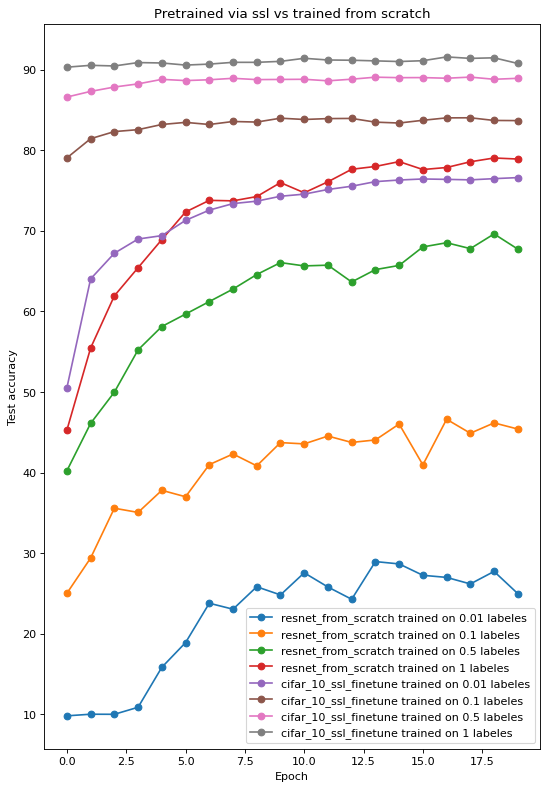

In [30]:
plt.figure(figsize=(8, 12), dpi=80)
for model_name in ["resnet_from_scratch", "cifar_10_ssl_finetune"]:
    for frac in [0.01, 0.1, 0.5, 1]:
        run_name = f"{model_name}/full_finetune_on_{frac}_labeles"
        ckpt_pth = Path("../outputs") / run_name / "checkpoint.pth.tar"
        ckpt = torch.load(ckpt_pth, map_location="cpu")

        ys = [float(x) for x in ckpt["val_acc_history"]]
        xs = np.arange(len(ys))

        plt.plot(xs, ys, "o-", label=f"{model_name} trained on {frac} labeles")


plt.xlabel("Epoch")
plt.ylabel("Test accuracy")
plt.legend()
plt.title("Pretrained via ssl vs trained from scratch")
plt.show()

## 5. Дообучение на caltech101

Сравним сначала предобученную на ImageNet [SimCLRv2](https://github.com/google-research/simclr) модель и модель обучаемую с нуля

### Подготовка данных

In [31]:
DATA_PATH = "../data"  # PATH TO THE DATASET

transformer = transforms.Compose(
    [
        transforms.Resize((224, 224)),  # scaling images to fixed size
        transforms.ToTensor(),  # converting to tensors
        transforms.Lambda(
            lambda x: torch.cat([x, x, x], 0) if x.shape[0] == 1 else x
        ),  # treat gray images
        transforms.Normalize(
            [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
        ),  # normalize image data per-channel
    ]
)

caltech101 = torchvision.datasets.Caltech101(
    root=DATA_PATH, download=True, transform=transformer
)
torch.manual_seed(0)
train_dset, test_dset = torch.utils.data.random_split(caltech101, [7000, 1677])

val_loader = torch.utils.data.DataLoader(
    test_dset,
    batch_size=BATCH_SIZE,
    num_workers=12,
    drop_last=True,
)

BATCH_SIZE = 32
NUM_WORKERS = 12

Files already downloaded and verified


In [32]:
# class_to_instances_caltech = {class_id: [] for class_id in range(101)}

# for i in range(len(train_dset)):
#     class_to_instances_caltech[train_dset[i][1]].append(i)


# np.save('class_to_instances_caltech.npy', class_to_instances_caltech)


class_to_instances_caltech = np.load(
    "class_to_instances_caltech.npy", allow_pickle="TRUE"
).item()

### Задание модели

In [33]:
from resnet import get_resnet


class ClassifierCaltech(nn.Module):
    def __init__(self, weights_path=None) -> None:
        super().__init__()
        model, _ = get_resnet(50, 1, 0)
        if weights_path is not None:
            model.load_state_dict(torch.load(weights_path)["resnet"])

        self.base_encoder = model

        self.linear_head = nn.Sequential(nn.Linear(2048, 101))

    def forward(self, images):
        hi = torch.squeeze(self.base_encoder(images))
        return self.linear_head(hi)

### Обучение классификатора

In [34]:
N_EPOCH = 20
prefix = "demo_"
for weights_path in [None, "../data/r50_1x_sk0.pth"]:
    for frac in [0.1, 0.3, 0.5, 1]:
        model = ClassifierCaltech(weights_path).to(device)
        if weights_path is None:
            model_name = prefix + "caltech_resnet_from_scratch"
        else:
            model_name = prefix + "caltech_resnet_ssl_finetune"
        run_name = f"{model_name}/full_finetune_on_{frac}_labeles"

        train_loader = take_portion_of_train_set(
            train_dset, frac, class_to_instances_caltech, BATCH_SIZE
        )
        train_linear(
            model=model,
            run_name=run_name,
            train_loader=train_loader,
            val_loader=val_loader,
            n_epoch=N_EPOCH,
            finetune_extractor=True,
        )

Epoch: [0][ 0/21]	Time  1.479 ( 1.479)	Data  1.287 ( 1.287)	LinearAcc@1   0.00 (  0.00)	LinearAcc@5   6.25 (  6.25)	Loss 4.6835e+00 (4.6835e+00)
Epoch: [0][10/21]	Time  0.183 ( 0.302)	Data  0.002 ( 0.121)	LinearAcc@1  28.12 ( 11.36)	LinearAcc@5  46.88 ( 25.85)	Loss 3.7170e+00 (4.5222e+00)
Epoch: [0][20/21]	Time  0.110 ( 0.242)	Data  0.002 ( 0.065)	LinearAcc@1  17.65 ( 13.85)	LinearAcc@5  47.06 ( 30.59)	Loss 4.0661e+00 (4.3720e+00)
Test: [ 0/26]	Time  1.400 ( 1.400)	Data  0.000 ( 0.000)	LinearAcc@1  12.50 ( 12.50)	LinearAcc@5  28.12 ( 28.12)	Loss 0.0000e+00 (0.0000e+00)
Test: [10/26]	Time  0.100 ( 0.218)	Data  0.000 ( 0.000)	LinearAcc@1  15.62 (  9.38)	LinearAcc@5  20.31 ( 23.86)	Loss 0.0000e+00 (0.0000e+00)
Test: [20/26]	Time  0.103 ( 0.163)	Data  0.000 ( 0.000)	LinearAcc@1   9.38 (  9.90)	LinearAcc@5  20.31 ( 23.96)	Loss 0.0000e+00 (0.0000e+00)
 * LinearAcc@1 9.555 LinearAcc@5 23.858
Epoch: [1][ 0/21]	Time  1.371 ( 1.371)	Data  1.190 ( 1.190)	LinearAcc@1  18.75 ( 18.75)	LinearAcc@5  3

KeyboardInterrupt: 

### Графики

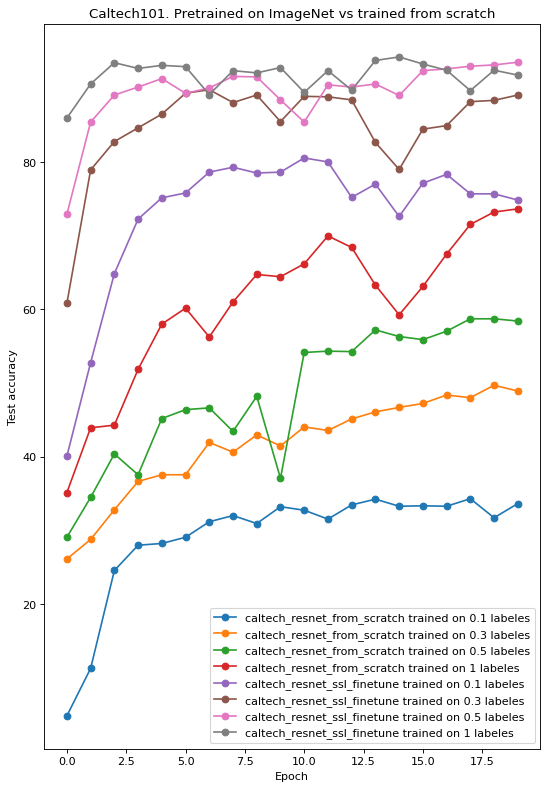

In [35]:
plt.figure(figsize=(8, 12), dpi=80)
for model_name in ["caltech_resnet_from_scratch", "caltech_resnet_ssl_finetune"]:
    for frac in [0.1, 0.3, 0.5, 1]:
        run_name = f"{model_name}/full_finetune_on_{frac}_labeles"
        ckpt_pth = Path("../outputs") / run_name / "checkpoint.pth.tar"
        ckpt = torch.load(ckpt_pth, map_location="cpu")

        ys = [float(x) for x in ckpt["val_acc_history"]]
        xs = np.arange(len(ys))

        plt.plot(xs, ys, "o-", label=f"{model_name} trained on {frac} labeles")


plt.xlabel("Epoch")
plt.ylabel("Test accuracy")
plt.legend()
plt.title("Caltech101. Pretrained on ImageNet vs trained from scratch")
plt.show()

### Предобучение на caltech101 предобученной на ImageNet модели

Предобучим на нашем наборе данных модель SimCLRv2 и сравним её точность с изначальной во время дообучения на небольшом числе лейблов

In [41]:
DATA_PATH = "../data"
OUT_PATH = Path("../outputs/caltech_101_ssl_v2")
OUT_PATH.mkdir(exist_ok=True)
BATCH_SIZE = 128
NUM_WORKERS = 12

N_EPOCH = 1000
LR = 1.0
MOMENTUM = 0.9
WD = 1e-6

In [42]:
# https://github.com/sthalles/SimCLR/blob/master/data_aug/gaussian_blur.py
import cv2


class GaussianBlur(object):
    # Implements Gaussian blur as described in the SimCLR paper
    def __init__(self, kernel_size, min=0.1, max=2.0):
        self.min = min
        self.max = max
        # kernel size is set to be 10% of the image height/width
        self.kernel_size = kernel_size

    def __call__(self, sample):
        sample = np.array(sample)

        # blur the image with a 50% chance
        prob = np.random.random_sample()

        if prob < 0.5:
            sigma = (self.max - self.min) * np.random.random_sample() + self.min
            sample = cv2.GaussianBlur(
                sample, (self.kernel_size, self.kernel_size), sigma
            )

        return sample

In [43]:
transform_train = transforms.Compose(
    [
        transforms.RandomResizedCrop((128, 128)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: torch.cat([x, x, x], 0) if x.shape[0] == 1 else x),
        transforms.ToPILImage(),
        transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        GaussianBlur(kernel_size=11),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

transform_test = transforms.Compose(
    [
        transforms.Resize((128, 128)),  # scaling images to fixed size
        transforms.ToTensor(),  # converting to tensors
        transforms.Lambda(
            lambda x: torch.cat([x, x, x], 0) if x.shape[0] == 1 else x
        ),  # treat gray images
        transforms.Normalize(
            [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
        ),  # normalize image data per-channel
    ]
)

caltech101 = torchvision.datasets.Caltech101(root=DATA_PATH, download=True)

# make train test split
torch.manual_seed(0)
train_dset, test_dset = torch.utils.data.random_split(caltech101, [7000, 1677])

caltech101_train = torchvision.datasets.Caltech101(
    root=DATA_PATH, download=True, transform=SimCLRDataTransform(transform_train)
)

caltech101_test = torchvision.datasets.Caltech101(
    root=DATA_PATH, download=True, transform=SimCLRDataTransform(transform_test)
)

train_dset = torch.utils.data.Subset(caltech101_train, train_dset.indices)
test_dset = torch.utils.data.Subset(caltech101_test, test_dset.indices)

train_loader = torch.utils.data.DataLoader(
    train_dset,
    batch_size=BATCH_SIZE,
    num_workers=12,
    drop_last=True,
)

val_loader = torch.utils.data.DataLoader(
    test_dset,
    batch_size=BATCH_SIZE,
    num_workers=12,
    drop_last=True,
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [44]:
from lars import LARS
from resnet import get_resnet

# load pretrained on ImageNet ssl model

resnet50_imagenet, _ = get_resnet(50, 1, 0)

resnet50_imagenet.load_state_dict(torch.load("../data/r50_1x_sk0.pth")["resnet"])

# self-supervised model
model = SimCLR(base_encoder=resnet50_imagenet).to(device)
optimizer = LARS(
    model.parameters(),
    lr=LR,
    momentum=MOMENTUM,
    weight_decay=WD,
)

# linear model
linear_classifier = nn.Sequential(nn.Linear(model.latent_dim, 101)).to(device)
optimizer_linear = torch.optim.SGD(
    linear_classifier.parameters(),
    lr=LR,
    momentum=MOMENTUM,
    nesterov=True,
)

# define schdulers
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, N_EPOCH, 0, -1)
scheduler_linear = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer_linear, N_EPOCH, 0, -1
)

In [45]:
best_loss = float("inf")
best_acc = 0.0
model.train()
for epoch in range(N_EPOCH):
    # train
    train(
        train_loader,
        model,
        linear_classifier,
        optimizer,
        optimizer_linear,
        epoch,
        device,
    )

    # validate
    val_loss, val_acc = validate(val_loader, model, linear_classifier, device)

    # update scheduler
    scheduler.step()
    scheduler_linear.step()

    # save checkpoint
    is_best = val_loss < best_loss
    best_loss = min(val_loss, best_loss)
    save_checkpoint(
        {
            "epoch": epoch + 1,
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "scheduler": scheduler.state_dict(),
            "state_dict_linear": linear_classifier.state_dict(),
            "optimizer_linear": optimizer_linear.state_dict(),
            "schedular_linear": scheduler_linear.state_dict(),
            "best_loss": best_loss,
            "best_acc": val_acc,
        },
        is_best,
        out_path=OUT_PATH,
    )

Epoch: [0][ 0/54]	Time  6.065 ( 6.065)	Data  5.392 ( 5.392)	LinearAcc@1   0.78 (  0.78)	LinearAcc@5   4.69 (  4.69)	Loss 4.7465e+00 (4.7465e+00)
Epoch: [0][10/54]	Time  0.593 ( 1.126)	Data  0.009 ( 0.517)	LinearAcc@1  60.16 ( 38.85)	LinearAcc@5  79.69 ( 55.68)	Loss 4.4694e+00 (4.6204e+00)
Epoch: [0][20/54]	Time  0.595 ( 0.875)	Data  0.010 ( 0.277)	LinearAcc@1  67.97 ( 51.60)	LinearAcc@5  91.41 ( 69.08)	Loss 4.1004e+00 (4.4350e+00)


KeyboardInterrupt: 

### Дообучение с разным числом лейблов

In [15]:
DATA_PATH = "../data"  # PATH TO THE DATASET
BATCH_SIZE = 32

transformer = transforms.Compose(
    [
        transforms.Resize((224, 224)),  # scaling images to fixed size
        transforms.ToTensor(),  # converting to tensors
        transforms.Lambda(
            lambda x: torch.cat([x, x, x], 0) if x.shape[0] == 1 else x
        ),  # treat gray images
        transforms.Normalize(
            [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
        ),  # normalize image data per-channel
    ]
)

caltech101 = torchvision.datasets.Caltech101(
    root=DATA_PATH, download=True, transform=transformer
)
torch.manual_seed(0)
train_dset, test_dset = torch.utils.data.random_split(caltech101, [7000, 1677])

val_loader = torch.utils.data.DataLoader(
    test_dset,
    batch_size=BATCH_SIZE,
    num_workers=12,
    drop_last=True,
)

class_to_instances_caltech = np.load(
    "class_to_instances_caltech.npy", allow_pickle="TRUE"
).item()

Files already downloaded and verified


In [16]:
from resnet import get_resnet

resnet50_imagenet, _ = get_resnet(50, 1, 0)

resnet50_imagenet.load_state_dict(torch.load("../data/r50_1x_sk0.pth")["resnet"])

# self-supervised model
model_ssl_caltech = SimCLR(base_encoder=resnet50_imagenet).to(device)

model_ssl_caltech.load_state_dict(
    torch.load("../outputs/caltech_101_ssl/model_best.pth.tar", map_location="cpu")[
        "state_dict"
    ]
)

<All keys matched successfully>

In [17]:
N_EPOCH = 20

prefix = "demo_"
model_name = prefix + "caltech_101_ssl_finetune"

for frac in [0.1, 0.3, 0.5, 1]:
    model = Classifier(model_ssl_caltech.base_encoder, num_classes=101).to(device)
    run_name = f"{model_name}/full_finetune_on_{frac}_labeles"

    train_loader = take_portion_of_train_set(
        train_dset, frac, class_to_instances_caltech, BATCH_SIZE
    )
    train_linear(
        model=model,
        run_name=run_name,
        train_loader=train_loader,
        val_loader=val_loader,
        n_epoch=N_EPOCH,
        finetune_extractor=True,
    )

Epoch: [0][ 0/21]	Time  1.536 ( 1.536)	Data  1.328 ( 1.328)	LinearAcc@1   0.00 (  0.00)	LinearAcc@5   3.12 (  3.12)	Loss 4.6329e+00 (4.6329e+00)
Epoch: [0][10/21]	Time  0.185 ( 0.308)	Data  0.004 ( 0.124)	LinearAcc@1  21.88 (  7.67)	LinearAcc@5  31.25 ( 15.34)	Loss 4.4800e+00 (4.5611e+00)
Epoch: [0][20/21]	Time  0.111 ( 0.246)	Data  0.002 ( 0.067)	LinearAcc@1  52.94 ( 18.72)	LinearAcc@5  58.82 ( 30.59)	Loss 4.2353e+00 (4.4649e+00)
Test: [ 0/52]	Time  1.457 ( 1.457)	Data  0.000 ( 0.000)	LinearAcc@1  34.38 ( 34.38)	LinearAcc@5  68.75 ( 68.75)	Loss 0.0000e+00 (0.0000e+00)
Test: [10/52]	Time  0.052 ( 0.180)	Data  0.000 ( 0.000)	LinearAcc@1  40.62 ( 42.05)	LinearAcc@5  71.88 ( 68.18)	Loss 0.0000e+00 (0.0000e+00)
Test: [20/52]	Time  0.053 ( 0.119)	Data  0.000 ( 0.000)	LinearAcc@1  46.88 ( 40.92)	LinearAcc@5  56.25 ( 63.39)	Loss 0.0000e+00 (0.0000e+00)
Test: [30/52]	Time  0.052 ( 0.098)	Data  0.000 ( 0.000)	LinearAcc@1  43.75 ( 41.03)	LinearAcc@5  75.00 ( 63.31)	Loss 0.0000e+00 (0.0000e+00)
T

KeyboardInterrupt: 

### Графики

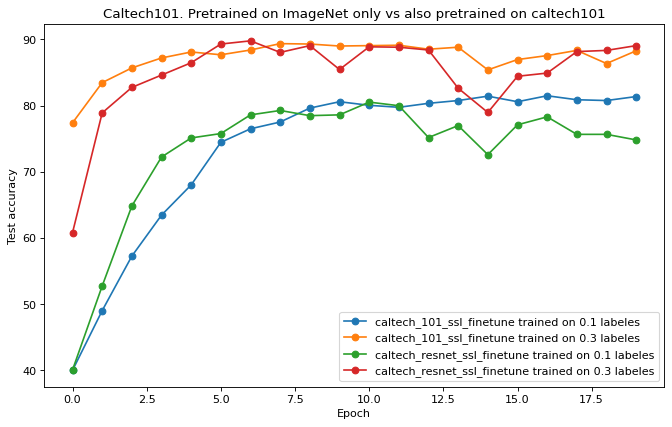

In [18]:
plt.figure(figsize=(10, 6), dpi=80)
for model_name in ["caltech_101_ssl_finetune", "caltech_resnet_ssl_finetune"]:
    for frac in [0.1, 0.3]:  # , 0.3, 0.5, 1]:
        run_name = f"{model_name}/full_finetune_on_{frac}_labeles"
        ckpt_pth = Path("../outputs") / run_name / "checkpoint.pth.tar"
        ckpt = torch.load(ckpt_pth, map_location="cpu")

        ys = [float(x) for x in ckpt["val_acc_history"]]
        xs = np.arange(len(ys))

        plt.plot(xs, ys, "o-", label=f"{model_name} trained on {frac} labeles")


plt.xlabel("Epoch")
plt.ylabel("Test accuracy")
plt.legend()
plt.title("Caltech101. Pretrained on ImageNet only vs also pretrained on caltech101")
plt.show()

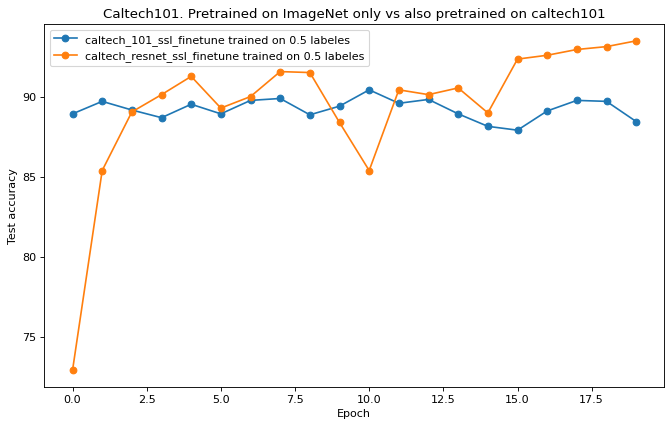

In [19]:
plt.figure(figsize=(10, 6), dpi=80)
for model_name in ["caltech_101_ssl_finetune", "caltech_resnet_ssl_finetune"]:
    for frac in [0.5]:  # , 0.3, 0.5, 1]:
        run_name = f"{model_name}/full_finetune_on_{frac}_labeles"
        ckpt_pth = Path("../outputs") / run_name / "checkpoint.pth.tar"
        ckpt = torch.load(ckpt_pth, map_location="cpu")

        ys = [float(x) for x in ckpt["val_acc_history"]]
        xs = np.arange(len(ys))

        plt.plot(xs, ys, "o-", label=f"{model_name} trained on {frac} labeles")


plt.xlabel("Epoch")
plt.ylabel("Test accuracy")
plt.legend()
plt.title("Caltech101. Pretrained on ImageNet only vs also pretrained on caltech101")
plt.show()

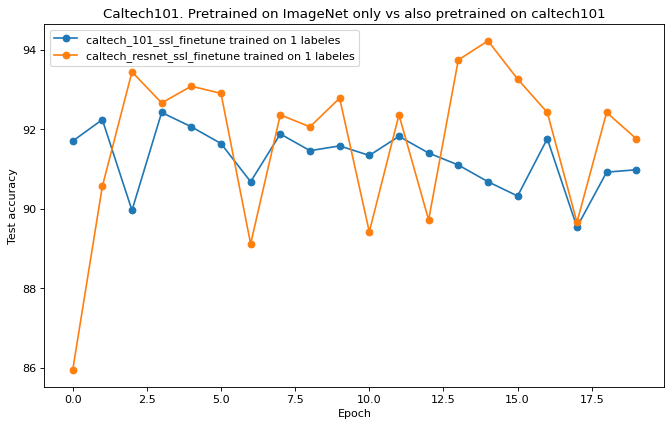

In [20]:
plt.figure(figsize=(10, 6), dpi=80)
for model_name in ["caltech_101_ssl_finetune", "caltech_resnet_ssl_finetune"]:
    for frac in [1]:  # , 0.3, 0.5, 1]:
        run_name = f"{model_name}/full_finetune_on_{frac}_labeles"
        ckpt_pth = Path("../outputs") / run_name / "checkpoint.pth.tar"
        ckpt = torch.load(ckpt_pth, map_location="cpu")

        ys = [float(x) for x in ckpt["val_acc_history"]]
        xs = np.arange(len(ys))

        plt.plot(xs, ys, "o-", label=f"{model_name} trained on {frac} labeles")


plt.xlabel("Epoch")
plt.ylabel("Test accuracy")
plt.legend()
plt.title("Caltech101. Pretrained on ImageNet only vs also pretrained on caltech101")
plt.show()

# Выводы
Мы обучили SimCLR-like модель на наборах данных CIFAR-10 и Caltech-101. После наших эксперементов мы можем уверенно заключить, что  
Предобученные с помощью контрастной функции потерь модели позволяют получить информативные эмбеддинги изображений,  
которые можно эффектино использовать для решения основной задачи, даже когда размеченных данных недостачно


## Обобщение SSL моделей
[Источник](https://arxiv.org/pdf/2011.13377.pdf)

<center><img src="../images/compare.png" alt="drawing" width="1300"/><center/>